# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ergetamuca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ergetamuca/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Use-Case Data!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 64, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [9]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '9b5a2b'. Skipping!
Property 'summary' already exists in node 'dc0164'. Skipping!
Property 'summary' already exists in node '067063'. Skipping!
Property 'summary' already exists in node 'a3ccbe'. Skipping!
Property 'summary' already exists in node '2a8757'. Skipping!
Property 'summary' already exists in node '85453c'. Skipping!
Property 'summary' already exists in node '451681'. Skipping!
Property 'summary' already exists in node 'fc0be7'. Skipping!
Property 'summary' already exists in node '6f183b'. Skipping!
Property 'summary' already exists in node '67f861'. Skipping!
Property 'summary' already exists in node '786538'. Skipping!
Property 'summary' already exists in node '6decfb'. Skipping!
Property 'summary' already exists in node '0323d8'. Skipping!
Property 'summary' already exists in node '270e2c'. Skipping!
Property 'summary' already exists in node '2f0d66'. Skipping!
Property 'summary' already exists in node 'd1ccea'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '2a8757'. Skipping!
Property 'summary_embedding' already exists in node 'a3ccbe'. Skipping!
Property 'summary_embedding' already exists in node '9b5a2b'. Skipping!
Property 'summary_embedding' already exists in node '067063'. Skipping!
Property 'summary_embedding' already exists in node '85453c'. Skipping!
Property 'summary_embedding' already exists in node 'dc0164'. Skipping!
Property 'summary_embedding' already exists in node '451681'. Skipping!
Property 'summary_embedding' already exists in node 'fc0be7'. Skipping!
Property 'summary_embedding' already exists in node '6f183b'. Skipping!
Property 'summary_embedding' already exists in node '0323d8'. Skipping!
Property 'summary_embedding' already exists in node '67f861'. Skipping!
Property 'summary_embedding' already exists in node '786538'. Skipping!
Property 'summary_embedding' already exists in node '6decfb'. Skipping!
Property 'summary_embedding' already exists in node '270e2c'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 86, relationships: 711)

We can save and load our knowledge graphs as follows.

In [10]:
kg.save("usecase_data_kg.json")
usecase_data_kg = KnowledgeGraph.load("usecase_data_kg.json")
usecase_data_kg

KnowledgeGraph(nodes: 86, relationships: 711)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [11]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [12]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

##### ✅ Answer:
1. SingleHopSpecificQuerySynthesizer: generates questions that can be answered by refering to one source of documents, without the need for connecting multiple sources. For example "What is the capital of Germany?". In our case, this type of query takes 50% of the overall distribution of generated questions. 

2. MultiHopAbstractQuerySynthesizer: generates questions that need to connect information from multiple documents but test the system's ability to synthsize information and form abstract / general conclusions. For example "What are the main themes across these documents?". In our case, this type of query constitutes 25% of the generated questions. 

3. MultiHopSpecificQuerySynthesizer: similar to the second one, generates questions that connect information from multiple documents, but it is connecting specific facts and pieces of info from these sources. For example "How does the information on Document A relate to the data in Document B?" Similar to the second one, this type of query constitutes 25% of generated questions. 

Finally, we can use our `TestSetGenerator` to generate our testset!

In [13]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What significance does the launch of ChatGPT i...,[Introduction ChatGPT launched in November 202...,Introduction ChatGPT launched in November 2022...,single_hop_specifc_query_synthesizer
1,In US what ChatGPT messages are mostly about?,[Table 1: ChatGPT daily message counts (millio...,"In the US, the majority of ChatGPT messages ar...",single_hop_specifc_query_synthesizer
2,What is Appendix D about in relation to ChatGP...,[Variation by Occupation Figure 23 presents va...,Appendix D contains a full report of GWA count...,single_hop_specifc_query_synthesizer
3,What is the significance of July 2025 in the c...,[Conclusion This paper studies the rapid growt...,"By July 2025, ChatGPT had been used weekly by ...",single_hop_specifc_query_synthesizer
4,How does the privaCY-preserving methdology hel...,[<1-hop>\n\nConclusion This paper studies the ...,The privacy-preserving methodology introduced ...,multi_hop_abstract_query_synthesizer
5,waht regretion analisis of occpation effcts an...,[<1-hop>\n\nVariation by Occupation Figure 23 ...,The context explains that variation in ChatGPT...,multi_hop_abstract_query_synthesizer
6,How does the use of privacy-preserving methods...,[<1-hop>\n\nConclusion This paper studies the ...,The study of ChatGPT's rapid growth and divers...,multi_hop_abstract_query_synthesizer
7,"Handa et al., 2025 show ChatGPT use for work a...",[<1-hop>\n\nIntroduction ChatGPT launched in N...,"Yes, according to the context, Handa et al., 2...",multi_hop_specific_query_synthesizer
8,Based on the growth in ChatGPT message volume ...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,The privacy-preserving analysis of user messag...,multi_hop_specific_query_synthesizer
9,How does the growth from 2.5 billion messages ...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,The increase from 2.5 billion messages per day...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '1e3463'. Skipping!
Property 'summary' already exists in node '12dc38'. Skipping!
Property 'summary' already exists in node '5114a1'. Skipping!
Property 'summary' already exists in node '3fa777'. Skipping!
Property 'summary' already exists in node 'a744eb'. Skipping!
Property 'summary' already exists in node 'bb497b'. Skipping!
Property 'summary' already exists in node '9d6b0e'. Skipping!
Property 'summary' already exists in node '3abbaa'. Skipping!
Property 'summary' already exists in node 'ec9604'. Skipping!
Property 'summary' already exists in node 'b44c31'. Skipping!
Property 'summary' already exists in node 'eb1ecc'. Skipping!
Property 'summary' already exists in node 'bdd2cc'. Skipping!
Property 'summary' already exists in node '19ca64'. Skipping!
Property 'summary' already exists in node '3fd1ee'. Skipping!
Property 'summary' already exists in node '23562e'. Skipping!
Property 'summary' already exists in node 'a6dc02'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '3abbaa'. Skipping!
Property 'summary_embedding' already exists in node '12dc38'. Skipping!
Property 'summary_embedding' already exists in node 'a744eb'. Skipping!
Property 'summary_embedding' already exists in node 'eb1ecc'. Skipping!
Property 'summary_embedding' already exists in node 'b44c31'. Skipping!
Property 'summary_embedding' already exists in node '1e3463'. Skipping!
Property 'summary_embedding' already exists in node 'ec9604'. Skipping!
Property 'summary_embedding' already exists in node '9d6b0e'. Skipping!
Property 'summary_embedding' already exists in node '3fa777'. Skipping!
Property 'summary_embedding' already exists in node '5114a1'. Skipping!
Property 'summary_embedding' already exists in node 'bb497b'. Skipping!
Property 'summary_embedding' already exists in node '3fd1ee'. Skipping!
Property 'summary_embedding' already exists in node '19ca64'. Skipping!
Property 'summary_embedding' already exists in node 'bdd2cc'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,what is november 2022,[Introduction ChatGPT launched in November 202...,Introduction ChatGPT launched in November 2022.,single_hop_specifc_query_synthesizer
1,How did the usage of ChatGPT change from June ...,[Month Non-Work (M) (%) Work (M) (%) Total Mes...,"In June 2024, ChatGPT messages consisted of 53...",single_hop_specifc_query_synthesizer
2,What is the significance of Handa in the conte...,[Total daily counts are exact measurements of ...,Handa is referenced in the context of a study ...,single_hop_specifc_query_synthesizer
3,What is the Secton used for in the context?,[Variation by Occupation Figure 23 presents va...,The context does not specify the use or meanin...,single_hop_specifc_query_synthesizer
4,Considering the variation in ChatGPT usage by ...,[<1-hop>\n\nVariation by Occupation Figure 23 ...,The context indicates that users in highly pai...,multi_hop_abstract_query_synthesizer
5,How does ChatGPT's increasing use for decision...,[<1-hop>\n\nConclusion This paper studies the ...,ChatGPT's growing use for decision support in ...,multi_hop_abstract_query_synthesizer
6,How does the measurement of message volume and...,[<1-hop>\n\nTotal daily counts are exact measu...,The measurement of message volume and activity...,multi_hop_abstract_query_synthesizer
7,How does the widespread use of ChatGPT for wor...,[<1-hop>\n\nConclusion This paper studies the ...,"Since its launch in November 2022, ChatGPT has...",multi_hop_abstract_query_synthesizer
8,Considering the rapid growth of ChatGPT usage ...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"The data shows that in June 2024, there were 4...",multi_hop_specific_query_synthesizer
9,Considering the rapid growth of ChatGPT usage ...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,The trend of increasing non-work-related queri...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [18]:
from langsmith import Client

client = Client()

dataset_name = "Use Case Synthetic Data - AIE8 Cohort"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [19]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [20]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [22]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [23]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG"
)

In [24]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [25]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

As is usual: We'll be using `gpt-4.1-mini` for our RAG!

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [27]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [28]:
rag_chain.invoke({"question" : "What are people doing with AI these days?"})

'Based on the provided context, people are using AI, particularly generative AI like ChatGPT, in various flexible ways both at work and outside of work. Specifically, AI is used to perform workplace tasks by either augmenting or automating human labor. Users employ AI to produce writing, software code, spreadsheets, and other digital products—capabilities that distinguish generative AI from traditional web search engines and existing technologies. Additionally, AI serves different user intents categorized as Asking (seeking information or advice), Doing (producing outputs or completing tasks), and Expressing (e.g., self-expression related to relationships, personal reflection, games, and role play). AI also acts as a co-worker producing output or as a co-pilot providing advice to improve human problem-solving productivity.\n\nIn summary, people are using AI for:\n\n- Automating or augmenting workplace tasks.\n- Creating digital content such as writing and code.\n- Seeking information a

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [29]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [30]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this response dope, lit, cool, or is it just a generic response?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

##### ✅ Answer:

- `qa_evaluator`: It's evaluating the correctness and accuracy of the responses, given the question. 
- `labeled_helpfulness_evaluator`: It's evaluating the helpfulness of the response to the user (practical use) by taking into account the correct reference answer. 
- `dopeness_evaluator`: It's evaluating whether the response is "dope" or simply a generic response. It's style based criteria evaluation, assessing how engaging the answer is. 

## LangSmith Evaluation

In [31]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'enchanted-stocking-92' at:
https://smith.langchain.com/o/307444e5-ae74-429f-974a-afd07b90d5e0/datasets/0941d419-845e-48c0-a7fe-dccd740758e1/compare?selectedSessions=a402d1b6-d779-423c-a7e5-742d9c869b98




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,"Jun 2024 non-work messages are more than half,...","In June 2024, non-work messages accounted for ...",None,"In June 2024, there were 451 million total mes...",1,1,0,2.753512,220ccbd7-3084-4be6-9bf8-ca80c3f413c1,c7238736-9fa6-48f4-9fc4-8bcc1322e786
1,Whatt is the messeges count in Jun 2025 and ho...,"The message count in June 2025 was 2,627 milli...",None,"In Jun 2025, the total messages sent were 2,62...",1,1,0,2.028067,926d7729-f7ca-47eb-8a8e-9e8c75585105,d5bbc774-c965-493d-b3d8-19ba900a2ded
2,Considering the rapid growth of ChatGPT usage ...,"Based on the provided context, the rapid growt...",None,The trend of increasing non-work-related queri...,1,1,0,4.969811,d9af4aaf-d800-407d-95be-690cc80f3102,9550621e-9183-45b9-8697-2052db62cd7f
3,Considering the rapid growth of ChatGPT usage ...,"Based on the provided context, between June 20...",None,"The data shows that in June 2024, there were 4...",1,1,0,5.096688,8a350bbb-c6dd-4e47-b358-08f45dbefdc8,0ad3d995-aef1-4dc8-be47-b8e5c1bb59f3
4,How does the widespread use of ChatGPT for wor...,The widespread use of ChatGPT for work-related...,None,"Since its launch in November 2022, ChatGPT has...",1,1,0,5.222296,48c82f6b-5216-4a61-ae40-815ba1f24d1d,4e718b71-6e3c-4e7b-986a-a23fa7f0ee3d
5,How does the measurement of message volume and...,The measurement of message volume and activity...,None,The measurement of message volume and activity...,1,1,0,3.250598,2aa42434-aad7-4a29-a611-7c8f8371e168,6b217de0-e42d-40e3-b0e1-5ff190e67987
6,How does ChatGPT's increasing use for decision...,"Based on the provided context, ChatGPT's incre...",None,ChatGPT's growing use for decision support in ...,1,1,0,3.018236,566cd13c-b5c5-405e-aef4-4fd7b8812f18,05535a30-cc6d-4255-9840-44081d8cb0ca
7,Considering the variation in ChatGPT usage by ...,"Based on the provided context, conversation to...",None,The context indicates that users in highly pai...,1,1,0,4.965642,15d5838d-dc61-4f9b-9f78-b04ecaa8e9b2,cebae63c-00bb-413d-95eb-6f091da31e2f
8,What is the Secton used for in the context?,I don't know.,None,The context does not specify the use or meanin...,1,0,0,0.489750,c93ca13f-22f7-4b9e-8890-2b957d1e6c46,bf84803b-2f23-4578-b32c-d66df3b25636
9,What is the significance of Handa in the conte...,Handa et al. (2025) are referenced in the cont...,None,Handa is referenced in the context of a study ...,1,1,0,3.654921,01428895-4cbc-4462-bfb2-dc76afe82f5f,af04adfd-abc6-4d00-9a13-f85b3556bf3a


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [32]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [33]:
rag_documents = docs

In [34]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

##### ✅ Answer:
- Larger chunks can contain more context and information than smaller chunks, which can increase the likelihood that the retrieved chunk may have the necessary information. 
- Smaller chunks may be too granular, and miss important contextual relationships
- The bigger size of chunks can help the embedding model in its work, that can lead to better semantic matching.
- However, larger chunks also mean that the answers may be diluted. There's a trade off to be considered with chunking size in terms of precision and coverage. 
- Chunk size can also impact computational processing ability - larger means less to process and store, and vice versa. 

In [35]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

##### ✅ Answer:
- It can impact the quality and accuracy of retrieval of documents. Higher quality embeddings capture semantic relationships better.
- It can impact how contextual nuances and domain specific aspects are handled. 
- It can impact the relevancy of the chunks that are retrieved. Higher likelihood of finding a chunk with the right answer.
- It can impact the ability to answer more complex, advanced questions, that require different resources to be connected, capture more niche concepts etc. 
- However, the trade off can be computational cost, and speed. Smaller models are cheaper and faster, than larger ones. It ultimately depends on what the desired end user experience is. 

In [36]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [37]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [38]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [39]:
dopeness_rag_chain.invoke({"question" : "How are people using AI to make money?"})

"Alright, buckle up — here’s the lowdown on how folks are cashing in on AI, straight from the dopest insights in the context.\n\nPeople aren’t just using AI as a magic wand to *do* their jobs directly. Nah, the true juice is in how AI, especially ChatGPT, functions as a *slick advisor* or a *research sidekick*. It’s like having a digital brainiac in your corner, boosting your decision-making game — which is clutch in knowledge-heavy gigs where sharp calls drive productivity sky-high.\n\nThink of it this way: AI powers up workers by lending decision support rather than stealing jobs. This makes knowledge workers faster, smarter, and more efficient, amping up their output without replacing them. This elevated decision quality isn’t just cool, it’s a straight-up economic supercharger.\n\nPlus, the economic wizard Collis and Brynjolfsson (2025) pegged the value of generative AI usage in the US at a staggering *consumer surplus of about $97 billion a year*. Translation? People *value* using

Finally, we can evaluate the new chain on the same test set!

In [40]:
evaluate(
    dopeness_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "dopeness_rag_chain"},
)

View the evaluation results for experiment: 'best-sign-26' at:
https://smith.langchain.com/o/307444e5-ae74-429f-974a-afd07b90d5e0/datasets/0941d419-845e-48c0-a7fe-dccd740758e1/compare?selectedSessions=77c57bfd-2e20-4996-8c71-88747a4ceecb




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,"Jun 2024 non-work messages are more than half,...","Alright, get ready to ride the wave of data co...",None,"In June 2024, there were 451 million total mes...",1,1,1,3.998642,220ccbd7-3084-4be6-9bf8-ca80c3f413c1,fe4eea82-1c2a-4d11-b8d0-68b74a860913
1,Whatt is the messeges count in Jun 2025 and ho...,"Yo, brace yourself for this wild growth saga! ...",None,"In Jun 2025, the total messages sent were 2,62...",1,1,1,3.499230,926d7729-f7ca-47eb-8a8e-9e8c75585105,9bfa32a3-b9a3-4037-965d-83d6be313685
2,Considering the rapid growth of ChatGPT usage ...,"Oh, you wanna dive into the rad wave ChatGPT i...",None,The trend of increasing non-work-related queri...,1,1,1,7.347466,d9af4aaf-d800-407d-95be-690cc80f3102,0db092c2-fd0f-42bc-ac89-979631d88e5a
3,Considering the rapid growth of ChatGPT usage ...,"Alright, strap in for some turbo-charged insig...",None,"The data shows that in June 2024, there were 4...",1,1,1,5.701168,8a350bbb-c6dd-4e47-b358-08f45dbefdc8,e2e766cb-507b-47c5-8511-79f690a75103
4,How does the widespread use of ChatGPT for wor...,"Alright, strap in — here’s the lowdown drippin...",None,"Since its launch in November 2022, ChatGPT has...",1,1,1,5.600245,48c82f6b-5216-4a61-ae40-815ba1f24d1d,7b3108e4-a543-444d-9b8c-ef55fe5da7ec
5,How does the measurement of message volume and...,"Yo, here’s the scoop slammed with juicy insigh...",None,The measurement of message volume and activity...,1,1,1,4.707604,2aa42434-aad7-4a29-a611-7c8f8371e168,5b49819c-702e-4b24-b9db-8a3598e0aad1
6,How does ChatGPT's increasing use for decision...,"Alright, buckle up for the ultimate brainwave:...",None,ChatGPT's growing use for decision support in ...,1,1,1,3.720959,566cd13c-b5c5-405e-aef4-4fd7b8812f18,55315f54-ede0-40ae-abd1-75fe42a04f2b
7,Considering the variation in ChatGPT usage by ...,"Alright, buckle up for some next-level insight...",None,The context indicates that users in highly pai...,1,1,1,10.908786,15d5838d-dc61-4f9b-9f78-b04ecaa8e9b2,347e6e04-7a71-4aff-bd6a-24979367b6d6
8,What is the Secton used for in the context?,"Yo, the context doesn’t outright spill the bea...",None,The context does not specify the use or meanin...,1,1,1,2.450664,c93ca13f-22f7-4b9e-8890-2b957d1e6c46,b0d5dc21-93ab-4947-93e0-115a0c899c18
9,What is the significance of Handa in the conte...,"Yo, Handa et al. (2025) is straight-up flexin'...",None,Handa is referenced in the context of a study ...,1,1,1,4.097798,01428895-4cbc-4462-bfb2-dc76afe82f5f,533926a9-b61b-4b09-97fe-36ade5b33f20


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

##### ✅ Answer:

The main changes between the experiments were:
- Changing the chunk size from 500--> 1000 characters. 
- Changing the embedding model from text-embedding-3-small --> text-embedding-3-large
- Adding explicit instructions for "dopeness" for more "dopey" responses instead of generic. 
- Removed k=10 limit for flexible retrieval. 

What we see: Improvements across the helpfulness and dopeness from the baseline experiment to the new one. Correctness has remained the same. 

What happened exactly and why: 

We do not see improvement in the answer correctness. This may be due to the following reasons: Even though the chunk size and embedding models may be bigger, the impact of these may be more on the recall (i.e relevancy of chunks) and not necessarily on the precision of the responses. There's a recall/precision trade off, which can also explain why helpfulness and dopeness improved in the meantime. 

We see improvement in the answer helpfulness. For this, the metrics likely improved, due to the following reasons:
- Larger chunks lead to more complete context. 
- Larger embedding model is providing better retrival accuracy due to improved embeddings. 
- The comprehensiveness of the answers is more helpful to the users. 

We see the most signficant improvement in the answer helpfulness. For this, the metrics improved, due to the following reasons:
- The answers are not generic, and are aligning to the "dopeness" instructions. 
- The dopeness change aligns with the engagement expectations from user. 

Overall, we see that Correctness <--> Precision; Helpfulness <--> Completeness and Dopeness <--> Engagement, and that the improvement in chunk size and embedding models, and removal retrival threshold help optimize for comprehensiveness and engagement rather than factual precision. 

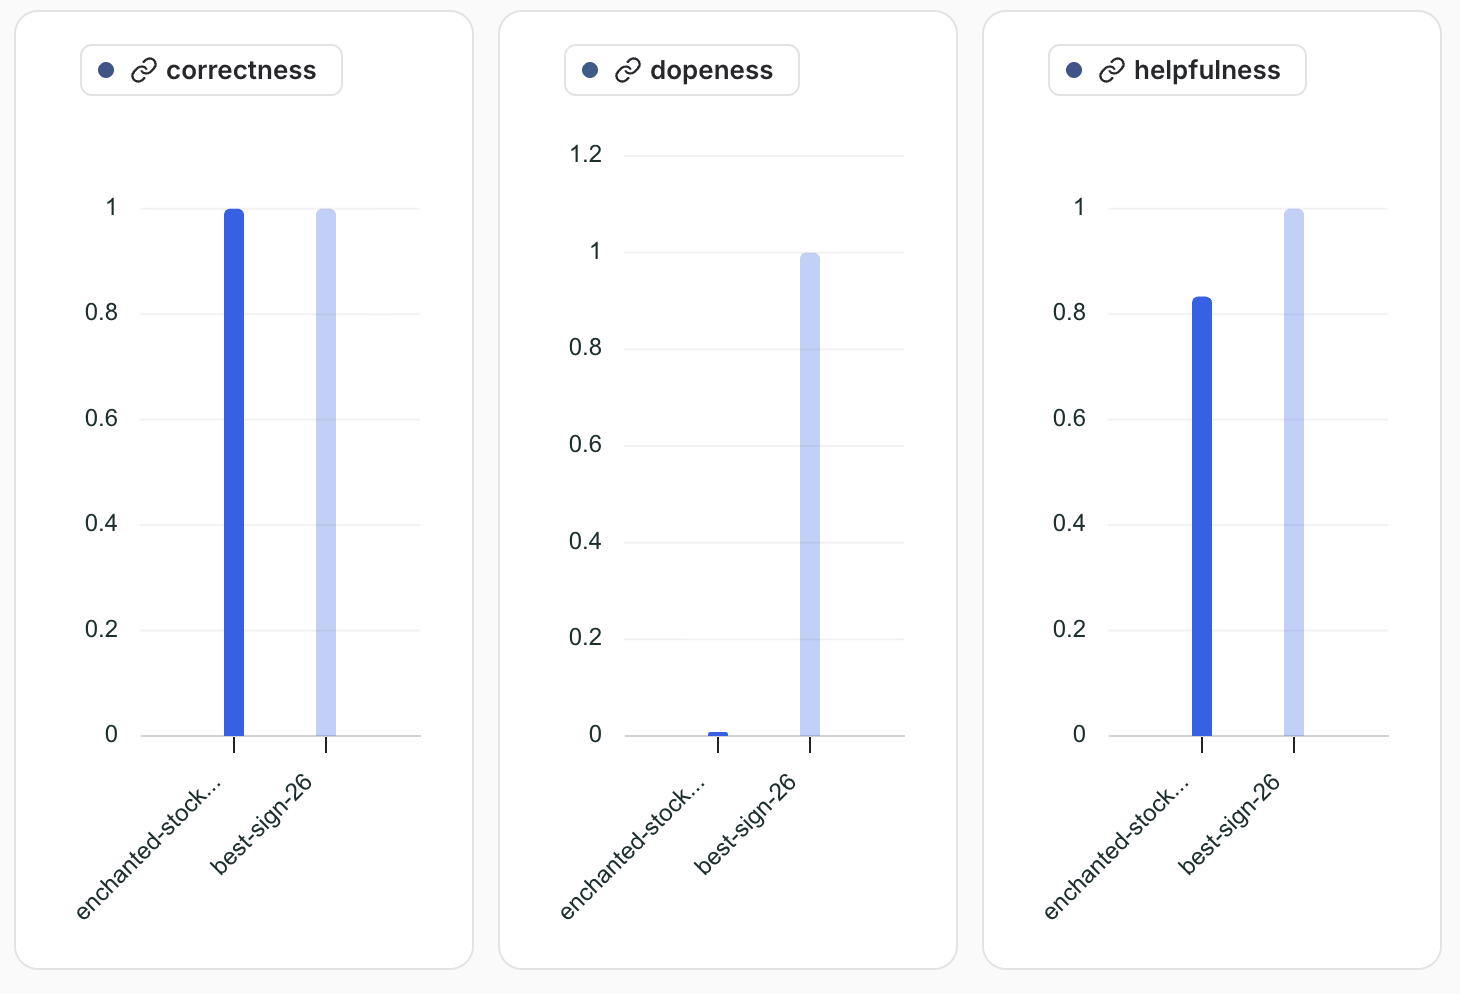

In [41]:
from IPython.display import Image
Image(filename='experiment charts.png')